### 필수 라이브러리 import

In [194]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import random
from keras.applications import VGG19,ResNet50
import random

-----------------

### cifar10 이미지 데이터 불러오기

In [2]:
(_, _), (test_x, test_y) = cifar10.load_data()

In [3]:
# 임시
# test_x = test_x[:1000]
# test_y = test_y[:1000]

--------------

### 사전 학습 모델 불러오기 (86.18% 정확도)

In [4]:
model = load_model('86_18.model')

##### 사전 학습 모델 정확도 확인

In [5]:
# 정확도 확인
predictTest = model.predict(test_x.astype(np.float32) / 255.0)

score = 0
for idx,label in enumerate(test_y):
    if predictTest[idx].argmax() == label:
        score += 1

print(score / len(test_y))

313/313 [==============================] - 7s 2ms/step
0.8618


------------

### 이미지 워터마크 클래스 정의

In [6]:
class WatermarkClass:
    def __init__(self, imgSize, watermark, alpha):
        #PIL의 putalpha 함수가 기존 이미지 데이터에 바로 반영하므로, 복제본 생성
        self.watermark = watermark.copy()
        self.watermark.putalpha(alpha)
        
        self.transparent = Image.new(mode='RGBA', size=imgSize, color=0)
        
    def ConvertAlphaToColor(self, image, color=(255, 255, 255)):
        back = Image.new('RGBA', size=image.size, color=color + (255,))
        front = image.copy()

        front = np.asarray(front)
        back = np.asarray(back)
        result = np.empty(front.shape, dtype='float')
        alpha = np.index_exp[:, :, 3:]
        rgb = np.index_exp[:, :, :3]
        falpha = front[alpha] / 255.0
        balpha = back[alpha] / 255.0
        result[alpha] = falpha + balpha * (1 - falpha)
        old_setting = np.seterr(invalid='ignore')
        result[rgb] = (front[rgb] * falpha + back[rgb] * balpha * (1 - falpha)) / result[alpha]
        np.seterr(**old_setting)
        result[alpha] *= 255
        np.clip(result, 0, 255)
        result = result.astype('uint8')
        result = Image.fromarray(result, 'RGBA')
    
        return result

    def PutWaterMark(self, img, position):
        #PIL의 paste 함수가 기존 이미지 데이터에 바로 반영하므로, 복제본 생성
        waterMarkedImg = self.transparent.copy()
        waterMarkedImg.paste(img)
        waterMarkedImg.paste(im=self.watermark, box=position, mask=self.watermark)
        
        return self.ConvertAlphaToColor(waterMarkedImg).convert('RGB')

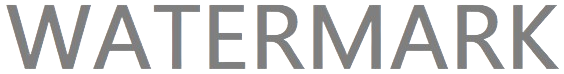

In [7]:
# 워터마크 이미지
Image.open('watermark.png')

In [8]:
watermarkClass = WatermarkClass(
    (32, 32), 
    Image.open('watermark.png').resize((16, 3)),
    127
)

### 워터마크 테스트

In [9]:
testImage = Image.fromarray(test_x[0])
watermarkedTestImage = watermarkClass.PutWaterMark(testImage, (10, 10))

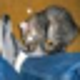

In [10]:
testImage.resize((80, 80))

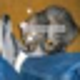

In [11]:
watermarkedTestImage.resize((80, 80))

-------------------

### 사전학습 모델 정확도 확인(원본이미지/워터마크이미지)

In [12]:
# 원본 이미지 확률
res = model.predict((test_x[0].astype(np.float32) / 255.0).reshape(1, 32, 32, 3))
res[0][res.argmax()]

1/1 [==============================] - 0s 82ms/step


0.9990349

In [13]:
# 워터마크 이미지 확률
res = model.predict(
    (
        np.array(
            watermarkClass.PutWaterMark(
                Image.fromarray(test_x[0]), (10, 10)
           )).astype(np.float32) / 255.0).reshape(1, 32, 32, 3)
)
res[0][res.argmax()]

1/1 [==============================] - 0s 19ms/step


0.8346056

In [14]:
del model

----------------
----------------

- CNN 모델 말고도 resnet 모델의 인식률도 효과적으로 떨어뜨린다는 것으로 보여줘야 함 (같은 워터마크 AI 모델로)
- 사실상 인식률 하락 정도에 대해서는 비교군이 없음 그냥 단일 모델로 어느정도 나온다고 실험해도 될 듯?
- 가장 하락시키는 것 대비 어느정도 완수하였는가!!!!???!?
    - 순차탐색 결과로, 분포를 저장해야 함. 최대/최대위치, 최소, 평균, 분산 인식률 등등
    
- 순차탐색을 어느 기존 AI모델로 하였는가에 따라 모델이 달라지는데!!!?!?!?!?!?!?!?!?
    - 일단 AI 모델에 따라 위치가 다른지를 살펴봐야 하고, 
    - 이거를 포인트로 잡아서 의미를 살펴보면 될 듯
    
- 워터마크를 넣었는데 오히려 정확도가 올라가는 케이스가 있다면??
- 이미지 분류 AI 모델별로 순차탐색 한 뒤, 모델간 최저 인식률 위치들의 유사성을 분석해야 함 (10,000 개 테스트 이미지 전체에 대해서 수행)
    - 유사하다면 유사한 대로 진행하고
    - 다르다면, 각각 진행해야 한다는 것으로 결론

------------

- 순차탐색 (CNN, VGG19, ResNet)
    - 10,000 개 테스트 이미지(이미지 분류 AI 모델의 학습에 사용되지 않은)를 train/test split
    - train, test 각각에 대해 모든 워터마크 위치별로 이미지를 복제 생성 (워터마크 되지 않은 이미지도 유지)
    - 순차탐색
        - 증강된 train 이미지들에 대해 이미지 분류 AI모델 predict 수행 후 정답 label 에 해당하는 softmax confidence 값을 기록한다 (이미지/위치/confidence)
        - 증강된 test 이미지들에 대해 이미지 분류 AI모델 predict 수행 후 정답 label 에 해당하는 softmax confidence 값을 기록한다 (이미지/위치/confidence)
    - 결과
        - CNN
            - train
                - 이미지1: 워터마크 없는 이미지의 정답 label의 confidence, 가장 큰 정확도 감소를 만드는 위치와 그 confidence, 전체 confidence 들의 평균, 분산
                - 이미지2: ...
            - test
                - ...
        - VGG19
            - ...
        - ResNet
            - ...
- 학습
    - 이미지 분류 AI 모델별로 수행
    - 학습데이터
        - x: 이미지
        - y: 가장 큰 정확도 감소를 만드는 x, y 위치
            - 문제는 가장 큰 정확도의 감소를 만드는 x, y의 위치가 하나가 아니라는 것 
                - 정확도 감소 만으로는 유일한 지점을 찾는 기준이 될 수 없다. 엔트로피도 마찬가지. 심지어는 동일한 100% 다른 라벨이 여러군데에서 관측되는 경우도 있음
            - 모델은 x와 y 사이의 명확한 패턴이나 관계를 학습하는 데 어려움을 겪습니다. 이는 주어진 입력 x에 대해 어떤 출력 y를 생성해야 하는지에 대해 충돌하는 신호를 수신하기 때문입니다.
            - 어느 하나를 사용하더라도 다른 이미지에 대해서 또 다른 하나를 사용했을 때, 이미지 별로 기준이 다를 수 있을 것 같다.
            - 위치가 하나가 아닌 이미지들은 아얘 학습에 사용 안하는 것으로 확정

- 테스팅
    - 스코어: 최대한 인식률을 하락시킬 수 있는 정도에 비해 몇%나 하락시켰는가

- ??
    - 신뢰도를 하락시키지만 정답을 유지할 것으로 생각했지만, 워터마크를 통해 이해할 수 없는 혼란을 주었음.
    
- AI 모델마다 워터마크에 대한 민감도가 다를 수 있습니다. 일부는 더 강력하고 워터마크를 무시하거나 우회할 수 있는 반면 다른 일부는 더 쉽게 혼동될 수 있습니다.

- 어떤 라벨의 인식률의 하락에 대해 학습할 것과 관련해, 정답라벨을 사용할지 모델의 예측 라벨을 사용할지 고민 필요
        

In [15]:
def MakeSearchspace(x, y, watermarkImageSize=(16, 3), alpha=127, model1=None, model2=None, model3=None):
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=2023)
    
    if model1 == None:
        model1 = load_model('86_18.model')
    if model2 == None:
        model2 = load_model('83_20.model')
    if model3 == None:
        model3 = load_model('80_61.model')
    
    result = {
        'image': {
            'train': [Image.fromarray(x) for x in train_x],
            'test': [Image.fromarray(x) for x in test_x],
        },
        'label': {
            'train': [y for y in train_y],
            'test': [y for y in test_y],
        },
        'CNN': {
            'model': model1,
            'train': [],
            'test': []
        },
        'VGG19': {
            'model': model2,
            'train': [],
            'test': []
        },
        'ResNet': {
            'model': model3,
            'train': [],
            'test': []
        }
    }
    
    watermarkClass = WatermarkClass(
        (32, 32), 
        Image.open('watermark.png').resize(watermarkImageSize),
        alpha
    )
    
    for modelName in result.keys():
        if modelName == 'image' or modelName == 'label':
            continue
        
        for dataset in [(train_x, train_y, 'train'), (test_x, test_y, 'test')]:
            print('\n' + modelName + ': ' + dataset[2])
            
            for imgIndex,imgArray in enumerate(dataset[0]):
                imageSpaceList = [imgArray]
                for pos_x in range(0, imgArray.shape[0] - watermarkImageSize[0] + 1):
                    for pos_y in range(0, imgArray.shape[1] - watermarkImageSize[1] + 1):
                        watermarkImg = watermarkClass.PutWaterMark(Image.fromarray(imgArray), (pos_x, pos_y))
                        imageSpaceList.append(watermarkImg)

                model = result[modelName]['model']
                predictArray = model.predict(np.stack(imageSpaceList, 0).astype(np.float32) / 255.0, verbose=0)

                result[modelName][dataset[2]].append(predictArray)
                
                print(f'\r{imgIndex + 1}/{len(dataset[0])}', end='')
    
    return result

In [16]:
%%time

model1 = load_model('86_18.model')
model2 = load_model('83_20.model')
model3 = load_model('80_61.model')

CPU times: total: 9.7 s
Wall time: 10.8 s


In [17]:
%%time

result = MakeSearchspace(test_x, test_y, model1=model1, model2=model2, model3=model3, alpha=127)


CNN: train
7000/7000
CNN: test
3000/3000
VGG16: train
7000/7000
VGG16: test
3000/3000
ResNet: train
7000/7000
ResNet: test
3000/3000CPU times: total: 4h 34min 30s
Wall time: 4h 30min 45s


### 데이터 생성 정상 확인

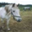

In [44]:
result['image']['train'][0]

In [45]:
result['label']['train'][0]

array([7], dtype=uint8)

In [47]:
# 워터마크 미지정 이미지 confidence array
result['CNN']['train'][0][0]

array([1.00814123e-05, 6.18595521e-08, 3.92981339e-04, 1.14726159e-03,
       3.31421848e-04, 4.67823260e-03, 1.02965419e-06, 9.93434429e-01,
       1.15838866e-07, 4.22309631e-06], dtype=float32)

In [68]:
result['CNN']['train'][0][0][result['CNN']['train'][0][0].argmax()]

0.9934344

In [70]:
# 워터마크를 찍고 모델을 통해 예측한 값
a = result['CNN']['model'].predict(
    (
        np.array(
            watermarkClass.PutWaterMark(result['image']['train'][0], (8, 12))
        ).astype(np.float32) / 255.0
    ).reshape((1, 32, 32, 3))
)[0][result['CNN']['train'][0][0].argmax()]

# 생성된 데이터에서 워터마크 찍힌 결과값에 바로 접근
b = result['CNN']['train'][0][8*30 + 12 + 1][result['CNN']['train'][0][0].argmax()]

# 두 값 비교
print(a, b)

1/1 [==============================] - 0s 26ms/step
0.95968705 0.95968705


### 워터마크AI모델 학습을 위한 데이터셋 생성 (단일 하락포인트를 가진 이미지 추출)

In [ ]:
def MakeWatermarkTrainDataset(data, model):
    
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    
    trainImageIdx = []
    testImageIdx = []
    
    for sets in [('train', train_x, train_y), ('test', test_x, test_y)]:
        for imgIdx, (img,label,predictArray) in enumerate(zip(data['image'][sets[0]], data['label'][sets[0]], data[model][sets[0]])):

            # 원본 이미지의 정답 라벨의 confidence 를 기록
            originalConfidence = predictArray[0][label]
            diff = 0
            same = False
            pos_x = None
            pos_y = None

            for pos_i,arr in enumerate(predictArray[1:]):
                if originalConfidence - arr[label] >= diff:
                    if originalConfidence - arr[label] == diff:
                        same = True
                    else:
                        same = False
                    diff = originalConfidence - arr[label]

                    pos_x = pos_i // 30
                    pos_y = pos_i % 30

            if same == True or pos_x == None or pos_y == None:
                None
            else:
                # print(sets[0], '{}번째 이미지'.format(imgIdx))
                if sets[0] == 'train':
                    trainImageIdx.append(imgIdx)
                elif sets[0] == 'test':
                    testImageIdx.append(imgIdx)
                    
                sets[1].append(np.array(img))
                sets[2].append((pos_x, pos_y))
    
    return train_x, train_y, test_x, test_y, trainImageIdx, testImageIdx

In [248]:
%%time

waterAITrainDatasetCNN = MakeWatermarkTrainDataset(result, 'CNN')
waterAITrainDatasetVGG19 = MakeWatermarkTrainDataset(result, 'VGG19')
waterAITrainDatasetResNet = MakeWatermarkTrainDataset(result, 'ResNet')

CPU times: total: 41.7 s
Wall time: 41.7 s


In [249]:
print('CNN 단일 하락포인트를 가진 이미지 수')
print('train:', len(waterAITrainDatasetCNN[0]))
print('test:', len(waterAITrainDatasetCNN[2]))

CNN 단일 하락포인트를 가진 이미지 수
train: 6741
test: 2902


In [250]:
print('VGG19 단일 하락포인트를 가진 이미지 수')
print('train:', len(waterAITrainDatasetVGG19[0]))
print('test:', len(waterAITrainDatasetVGG19[2]))

VGG19 단일 하락포인트를 가진 이미지 수
train: 6433
test: 2721


In [251]:
print('ResNet 단일 하락포인트를 가진 이미지 수')
print('train:', len(waterAITrainDatasetResNet[0]))
print('test:', len(waterAITrainDatasetResNet[2]))

ResNet 단일 하락포인트를 가진 이미지 수
train: 6725
test: 2883


- 최대 하락 위치가 한군데인 이미지들에 대해서만 학습.

- 검증은 최대 하락 위치가 여러군데인 이미지 들에 대해서 수행 (해도 되나?)
    - 워터마킹 후 하락 정도 확인했을 때 해당 이미지의 모든 위치에 대한 하락 분포에서 어느 위치에 위치하는지 비쥬얼하게 보여주고, 전체 통계 또한 보여주면 좋을 듯

----------------
----------------

In [252]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [253]:
def CreateCNNModel():
    inputs = Input(shape=(32, 32, 3))
    tensor = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    tensor = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(tensor)
    tensor = MaxPool2D(pool_size=(2,2))(tensor)
    tensor = Dropout(0.25)(tensor)
    
    tensor = Conv2D(filters = 64, kernel_size=(3, 3), activation='relu', padding='same')(tensor)
    tensor = Conv2D(filters = 64, kernel_size=(3, 3), activation='relu', padding='same')(tensor)
    tensor = MaxPool2D(pool_size=(2,2))(tensor)
    tensor = Dropout(0.25)(tensor)
    
    tensor = Conv2D(filters = 128, kernel_size=(3, 3), activation='relu', padding='same')(tensor)
    tensor = MaxPool2D(pool_size=(2,2))(tensor)
    tensor = Dropout(0.25)(tensor)
    tensor = Conv2D(filters = 128, kernel_size=(3, 3), activation='relu', padding='same')(tensor)
    tensor = MaxPool2D(pool_size=(2,2))(tensor)
    tensor = Dropout(0.25)(tensor)
    tensor = Conv2D(filters = 256, kernel_size=(3, 3), activation='relu', padding='same')(tensor)
    tensor = MaxPool2D(pool_size=(2,2))(tensor)
    tensor = Dropout(0.25)(tensor)
    
    tensor = Flatten()(tensor)
    
    tensor = Dense(128, activation='relu')(tensor)
    tensor = Dropout(0.5)(tensor)
    outputs = Dense(2, activation='linear')(tensor)

    model = Model(inputs, outputs)
    
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    
    return model

In [254]:
def CreateVGG19Model():
    baseModel = VGG19(include_top=False,weights='imagenet',input_shape=(32,32,3))
    
    model= Sequential()
    model.add(baseModel)
    model.add(Flatten())
    
    model.add(Dense(1024,activation=('relu'),input_dim=512))
    model.add(Dense(512,activation=('relu'))) 
    model.add(Dense(256,activation=('relu'))) 
    model.add(Dense(128,activation=('relu')))
    model.add(Dense(2,activation=('linear'))) #This is the classification layer
    
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    
    return model

In [255]:
def CreateResNetModel():
    baseModel = ResNet50(include_top=False,weights='imagenet',input_shape=(32,32,3))
    
    model= Sequential()
    model.add(baseModel)
    model.add(Flatten())
    
    model.add(Dense(1024,activation=('relu')))
    model.add(Dense(512,activation=('relu'))) 
    model.add(Dense(256,activation=('relu'))) 
    model.add(Dense(128,activation=('relu')))
    model.add(Dense(2,activation=('linear'))) #This is the classification layer
    
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    
    return model

In [256]:
modelCNN = CreateCNNModel()
modelVGG19 = CreateVGG19Model()
modelResNet = CreateResNetModel()

-----------------
-----------------

### CNN 모델 학습

In [257]:
historyCNN = modelCNN.fit(
    np.array(waterAITrainDatasetCNN[0]).astype(np.float32) / 255.0, 
    np.array(waterAITrainDatasetCNN[1]), 
    validation_data=(
        np.array(waterAITrainDatasetCNN[2]).astype(np.float32) / 255.0, 
        np.array(waterAITrainDatasetCNN[3])
    ), 
    epochs=50
)

Epoch 1/50
211/211 [==============================] - 3s 12ms/step - loss: 45.9578 - mse: 45.9578 - val_loss: 43.9712 - val_mse: 43.9712
Epoch 2/50
211/211 [==============================] - 2s 10ms/step - loss: 37.0115 - mse: 37.0115 - val_loss: 31.2063 - val_mse: 31.2063
Epoch 3/50
211/211 [==============================] - 2s 10ms/step - loss: 35.1534 - mse: 35.1534 - val_loss: 31.8175 - val_mse: 31.8175
Epoch 4/50
211/211 [==============================] - 2s 10ms/step - loss: 34.7970 - mse: 34.7970 - val_loss: 34.6188 - val_mse: 34.6188
Epoch 5/50
211/211 [==============================] - 2s 10ms/step - loss: 34.3207 - mse: 34.3207 - val_loss: 30.2792 - val_mse: 30.2792
Epoch 6/50
211/211 [==============================] - 2s 10ms/step - loss: 33.3768 - mse: 33.3768 - val_loss: 29.8371 - val_mse: 29.8371
Epoch 7/50
211/211 [==============================] - 2s 10ms/step - loss: 33.5711 - mse: 33.5711 - val_loss: 29.8418 - val_mse: 29.8418
Epoch 8/50
211/211 [=====================

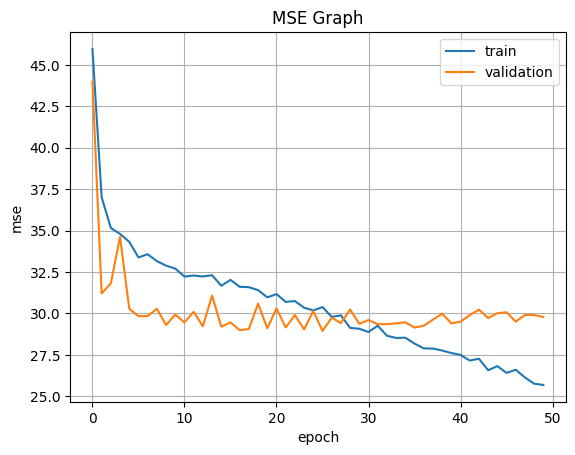

In [258]:
plt.plot(historyCNN.history['mse'])
plt.plot(historyCNN.history['val_mse'])
plt.title('MSE Graph')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.grid()
plt.show()

### 모델 위치 정상 예측 확인

In [259]:
# train 데이터셋 첫번째 이미지의 최대하락 위치 예측
modelCNN.predict((np.array(result['image']['train'][0]).astype(np.float32) / 255.0).reshape((1, 32, 32, 3)))

1/1 [==============================] - 0s 93ms/step


array([[ 9.822588 , 15.3883095]], dtype=float32)

### 모델 예측에 대한 테스트 데이터셋 오차 확인

In [260]:
xSum = 0
ySum = 0
for idx,res in enumerate(zip(modelCNN.predict(np.array(waterAITrainDatasetCNN[2]).astype(np.float32) / 255.0), waterAITrainDatasetCNN[3])):
    xSum += abs(res[0][0] - res[1][0])
    ySum += abs(res[0][1] - res[1][1])

print('x평균오차: {}, y평균오차: {}'.format(xSum/idx, ySum/idx))

91/91 [==============================] - 0s 2ms/step
x평균오차: 3.91771790012332, y평균오차: 4.882160582077253


### 랜덤 지정에 대한 테스트 데이터셋 오차 확인

In [261]:
randList = []
for xy in zip(random.choices(range(0,17), k=len(waterAITrainDatasetCNN[3])), random.choices(range(0,30), k=len(waterAITrainDatasetCNN[3]))):
    randList.append(xy)

xSum = 0
ySum = 0
for idx,res in enumerate(zip(randList, waterAITrainDatasetCNN[3])):
    xSum += abs(res[0][0] - res[1][0])
    ySum += abs(res[0][1] - res[1][1])

print('x평균오차: {}, y평균오차: {}'.format(xSum/idx, ySum/idx))

x평균오차: 5.4257152705963465, y평균오차: 9.08031713202344


------------------
------------------

### CNN인식 모델에서 예측위치의 confidence 하락률 검증 (테스트 데이터셋 대상)

In [262]:
modelName='CNN'
averageDown = 0

for data in zip(modelCNN.predict(np.array(waterAITrainDatasetCNN[2]).astype(np.float32) / 255.0), waterAITrainDatasetCNN[5]):
    
    noWatermarkImageConfidenceArray = result[modelName]['test'][data[1]][0]
    # 이미지AI 모델의 원본이미지에 대한 confidence
    imageAILabelNoWatermarkImageConfidence = noWatermarkImageConfidenceArray[noWatermarkImageConfidenceArray.argmax()]
    
    # 만약 이미지 크기를 벗어낫 위치를 예측한다면 pass
    if (int(data[0][0]) * 30) + int(data[0][1]) + 1 >= 511:
        print('!!!!!over pass')
        continue
    
    # 워터마크 위치AI가 예측한 위치의 이미지AI(CNN)의 인식률 확인
    watermarkPositionAIModelConfidence = result[modelName]['test'][
        data[1]                             # 이미지 번호
    ][
        (int(data[0][0]) * 30) +            # x축 위치
        int(data[0][1]) +                   # y축 위치
        + 1                                 # 가장 앞에 원본 이미지가 있으므로 +1
    ][
        noWatermarkImageConfidenceArray.argmax()    # 이미지 AI 가 예측한 라벨
    ]
    
    #print('{} -> {}'.format(imageAILabelNoWatermarkImageConfidence, watermarkPositionAIModelConfidence))
    averageDown += (imageAILabelNoWatermarkImageConfidence - watermarkPositionAIModelConfidence) / imageAILabelNoWatermarkImageConfidence * 100

print('평균 하락율(%): ', averageDown / idx)

91/91 [==============================] - 0s 3ms/step
평균 하락율(%):  11.98974522534012


------------------------
------------------------

### VGG19인식 모델에서 예측위치의 confidence 하락률 검증 (테스트 데이터셋 대상)

In [263]:
modelName='VGG19'
averageDown = 0

for data in zip(modelCNN.predict(np.array(waterAITrainDatasetVGG19[2]).astype(np.float32) / 255.0), waterAITrainDatasetVGG19[5]):
    
    noWatermarkImageConfidenceArray = result[modelName]['test'][data[1]][0]
    # 이미지AI 모델의 원본이미지에 대한 confidence
    imageAILabelNoWatermarkImageConfidence = noWatermarkImageConfidenceArray[noWatermarkImageConfidenceArray.argmax()]
    
    # 만약 이미지 크기를 벗어낫 위치를 예측한다면 pass
    if (int(data[0][0]) * 30) + int(data[0][1]) + 1 >= 511:
        print('!!!!!over pass')
        continue
    
    # 워터마크 위치AI가 예측한 위치의 이미지AI(CNN)의 인식률 확인
    watermarkPositionAIModelConfidence = result[modelName]['test'][
        data[1]                             # 이미지 번호
    ][
        (int(data[0][0]) * 30) +            # x축 위치
        int(data[0][1]) +                   # y축 위치
        + 1                                 # 가장 앞에 원본 이미지가 있으므로 +1
    ][
        noWatermarkImageConfidenceArray.argmax()    # 이미지 AI 가 예측한 라벨
    ]
    
    #print('{} -> {}'.format(imageAILabelNoWatermarkImageConfidence, watermarkPositionAIModelConfidence))
    averageDown += (imageAILabelNoWatermarkImageConfidence - watermarkPositionAIModelConfidence) / imageAILabelNoWatermarkImageConfidence * 100

print('평균 하락율(%): ', averageDown / idx)

86/86 [==============================] - 0s 3ms/step
평균 하락율(%):  16.232352284333427


------------------------
------------------------

### ResNet인식 모델에서 예측위치의 confidence 하락률 검증 (테스트 데이터셋 대상)

In [264]:
modelName='ResNet'
averageDown = 0

for data in zip(modelCNN.predict(np.array(waterAITrainDatasetResNet[2]).astype(np.float32) / 255.0), waterAITrainDatasetResNet[5]):
    
    noWatermarkImageConfidenceArray = result[modelName]['test'][data[1]][0]
    # 이미지AI 모델의 원본이미지에 대한 confidence
    imageAILabelNoWatermarkImageConfidence = noWatermarkImageConfidenceArray[noWatermarkImageConfidenceArray.argmax()]
    
    # 만약 이미지 크기를 벗어낫 위치를 예측한다면 pass
    if (int(data[0][0]) * 30) + int(data[0][1]) + 1 >= 511:
        print('!!!!!over pass')
        continue
    
    # 워터마크 위치AI가 예측한 위치의 이미지AI(CNN)의 인식률 확인
    watermarkPositionAIModelConfidence = result[modelName]['test'][
        data[1]                             # 이미지 번호
    ][
        (int(data[0][0]) * 30) +            # x축 위치
        int(data[0][1]) +                   # y축 위치
        + 1                                 # 가장 앞에 원본 이미지가 있으므로 +1
    ][
        noWatermarkImageConfidenceArray.argmax()    # 이미지 AI 가 예측한 라벨
    ]
    
    #print('{} -> {}'.format(imageAILabelNoWatermarkImageConfidence, watermarkPositionAIModelConfidence))
    averageDown += (imageAILabelNoWatermarkImageConfidence - watermarkPositionAIModelConfidence) / imageAILabelNoWatermarkImageConfidence * 100

print('평균 하락율(%): ', averageDown / idx)

91/91 [==============================] - 0s 3ms/step
평균 하락율(%):  11.541703606740624


-------------------
-------------------

### VGG19 모델 학습

In [265]:
historyVGG19 = modelVGG19.fit(
    np.array(waterAITrainDatasetVGG19[0]).astype(np.float32) / 255.0, 
    np.array(waterAITrainDatasetVGG19[1]), 
    validation_data=(
        np.array(waterAITrainDatasetVGG19[2]).astype(np.float32) / 255.0, 
        np.array(waterAITrainDatasetVGG19[3])
    ), 
    epochs=50
)

Epoch 1/50
202/202 [==============================] - 6s 26ms/step - loss: 1024048.3750 - mse: 1024048.3750 - val_loss: 31.6170 - val_mse: 31.6170
Epoch 2/50
202/202 [==============================] - 5s 24ms/step - loss: 32.6274 - mse: 32.6274 - val_loss: 34.0726 - val_mse: 34.0726
Epoch 3/50
202/202 [==============================] - 5s 22ms/step - loss: 31.7351 - mse: 31.7351 - val_loss: 30.8458 - val_mse: 30.8458
Epoch 4/50
202/202 [==============================] - 5s 24ms/step - loss: 30.1888 - mse: 30.1888 - val_loss: 31.3289 - val_mse: 31.3289
Epoch 5/50
202/202 [==============================] - 5s 24ms/step - loss: 29.7371 - mse: 29.7371 - val_loss: 28.1053 - val_mse: 28.1053
Epoch 6/50
202/202 [==============================] - 5s 24ms/step - loss: 29.2840 - mse: 29.2840 - val_loss: 28.8027 - val_mse: 28.8027
Epoch 7/50
202/202 [==============================] - 5s 25ms/step - loss: 28.9562 - mse: 28.9562 - val_loss: 30.8355 - val_mse: 30.8355
Epoch 8/50
202/202 [===========

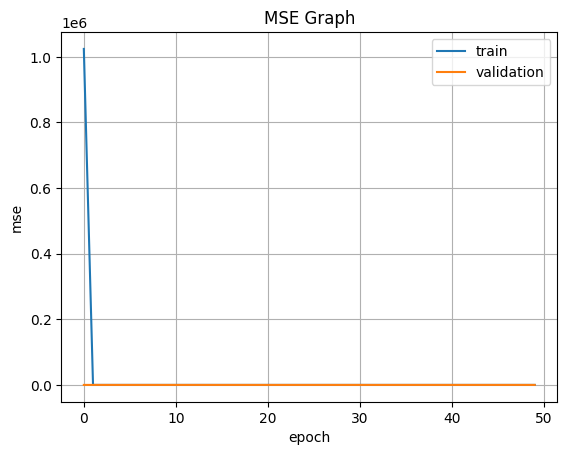

In [266]:
plt.plot(historyVGG19.history['mse'])
plt.plot(historyVGG19.history['val_mse'])
plt.title('MSE Graph')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.grid()
plt.show()

### 모델 위치 정상 예측 확인

In [267]:
# train 데이터셋 첫번째 이미지의 최대하락 위치 예측
modelVGG19.predict((np.array(result['image']['train'][0]).astype(np.float32) / 255.0).reshape((1, 32, 32, 3)))

1/1 [==============================] - 0s 162ms/step


array([[ 8.225053, 21.60742 ]], dtype=float32)

### 모델 예측에 대한 테스트 데이터셋 오차 확인

In [268]:
xSum = 0
ySum = 0
for idx,res in enumerate(zip(modelVGG19.predict(np.array(waterAITrainDatasetVGG19[2]).astype(np.float32) / 255.0), waterAITrainDatasetVGG19[3])):
    xSum += abs(res[0][0] - res[1][0])
    ySum += abs(res[0][1] - res[1][1])

print('x평균오차: {}, y평균오차: {}'.format(xSum/idx, ySum/idx))

86/86 [==============================] - 0s 6ms/step
x평균오차: 3.9045872232493233, y평균오차: 5.024528083205223


### 랜덤 지정에 대한 테스트 데이터셋 오차 확인

In [269]:
randList = []
for xy in zip(random.choices(range(0,17), k=len(waterAITrainDatasetVGG19[3])), random.choices(range(0,30), k=len(waterAITrainDatasetVGG19[3]))):
    randList.append(xy)

xSum = 0
ySum = 0
for idx,res in enumerate(zip(randList, waterAITrainDatasetVGG19[3])):
    xSum += abs(res[0][0] - res[1][0])
    ySum += abs(res[0][1] - res[1][1])

print('x평균오차: {}, y평균오차: {}'.format(xSum/idx, ySum/idx))

x평균오차: 5.651470588235294, y평균오차: 8.934191176470588


------------------
------------------

### CNN인식 모델에서 예측위치의 confidence 하락률 검증 (테스트 데이터셋 대상)

In [270]:
modelName='CNN'
averageDown = 0

for data in zip(modelVGG19.predict(np.array(waterAITrainDatasetCNN[2]).astype(np.float32) / 255.0), waterAITrainDatasetCNN[5]):
    
    noWatermarkImageConfidenceArray = result[modelName]['test'][data[1]][0]
    # 이미지AI 모델의 원본이미지에 대한 confidence
    imageAILabelNoWatermarkImageConfidence = noWatermarkImageConfidenceArray[noWatermarkImageConfidenceArray.argmax()]
    
    # 만약 이미지 크기를 벗어낫 위치를 예측한다면 pass
    if (int(data[0][0]) * 30) + int(data[0][1]) + 1 >= 511:
        print('!!!!!over pass')
        continue
    
    # 워터마크 위치AI가 예측한 위치의 이미지AI(CNN)의 인식률 확인
    watermarkPositionAIModelConfidence = result[modelName]['test'][
        data[1]                             # 이미지 번호
    ][
        (int(data[0][0]) * 30) +            # x축 위치
        int(data[0][1]) +                   # y축 위치
        + 1                                 # 가장 앞에 원본 이미지가 있으므로 +1
    ][
        noWatermarkImageConfidenceArray.argmax()    # 이미지 AI 가 예측한 라벨
    ]
    
    #print('{} -> {}'.format(imageAILabelNoWatermarkImageConfidence, watermarkPositionAIModelConfidence))
    averageDown += (imageAILabelNoWatermarkImageConfidence - watermarkPositionAIModelConfidence) / imageAILabelNoWatermarkImageConfidence * 100

print('평균 하락율(%): ', averageDown / idx)

91/91 [==============================] - 1s 7ms/step
평균 하락율(%):  12.912054791513667


------------------------
------------------------

### VGG19인식 모델에서 예측위치의 confidence 하락률 검증 (테스트 데이터셋 대상)

In [271]:
modelName='VGG19'
averageDown = 0

for data in zip(modelVGG19.predict(np.array(waterAITrainDatasetVGG19[2])).astype(np.float32) / 255.0, waterAITrainDatasetVGG19[5]):
    
    noWatermarkImageConfidenceArray = result[modelName]['test'][data[1]][0]
    # 이미지AI 모델의 원본이미지에 대한 confidence
    imageAILabelNoWatermarkImageConfidence = noWatermarkImageConfidenceArray[noWatermarkImageConfidenceArray.argmax()]
    
    # 만약 이미지 크기를 벗어낫 위치를 예측한다면 pass
    if (int(data[0][0]) * 30) + int(data[0][1]) + 1 >= 511:
        print('!!!!!over pass')
        continue
    
    # 워터마크 위치AI가 예측한 위치의 이미지AI(VGG19)의 인식률 확인
    watermarkPositionAIModelConfidence = result[modelName]['test'][
        data[1]                             # 이미지 번호
    ][
        (int(data[0][0]) * 30) +            # x축 위치
        int(data[0][1]) +                   # y축 위치
        + 1                                 # 가장 앞에 원본 이미지가 있으므로 +1
    ][
        noWatermarkImageConfidenceArray.argmax()    # 이미지 AI 가 예측한 라벨
    ]
    
    #print('{} -> {}'.format(imageAILabelNoWatermarkImageConfidence, watermarkPositionAIModelConfidence))
    averageDown += (imageAILabelNoWatermarkImageConfidence - watermarkPositionAIModelConfidence) / imageAILabelNoWatermarkImageConfidence * 100

print('평균 하락율(%): ', averageDown / idx)

86/86 [==============================] - 1s 6ms/step
평균 하락율(%):  3.600770006579061


------------------------
------------------------

### ResNet인식 모델에서 예측위치의 confidence 하락률 검증 (테스트 데이터셋 대상)

In [272]:
modelName='ResNet'
averageDown = 0

for data in zip(modelVGG19.predict(np.array(waterAITrainDatasetResNet[2])).astype(np.float32) / 255.0, waterAITrainDatasetResNet[5]):
    
    noWatermarkImageConfidenceArray = result[modelName]['test'][data[1]][0]
    # 이미지AI 모델의 원본이미지에 대한 confidence
    imageAILabelNoWatermarkImageConfidence = noWatermarkImageConfidenceArray[noWatermarkImageConfidenceArray.argmax()]
    
    # 만약 이미지 크기를 벗어낫 위치를 예측한다면 pass
    if (int(data[0][0]) * 30) + int(data[0][1]) + 1 >= 511:
        print('!!!!!over pass')
        continue
    
    # 워터마크 위치AI가 예측한 위치의 이미지AI(ResNet)의 인식률 확인
    watermarkPositionAIModelConfidence = result[modelName]['test'][
        data[1]                             # 이미지 번호
    ][
        (int(data[0][0]) * 30) +            # x축 위치
        int(data[0][1]) +                   # y축 위치
        + 1                                 # 가장 앞에 원본 이미지가 있으므로 +1
    ][
        noWatermarkImageConfidenceArray.argmax()    # 이미지 AI 가 예측한 라벨
    ]
    
    #print('{} -> {}'.format(imageAILabelNoWatermarkImageConfidence, watermarkPositionAIModelConfidence))
    averageDown += (imageAILabelNoWatermarkImageConfidence - watermarkPositionAIModelConfidence) / imageAILabelNoWatermarkImageConfidence * 100

print('평균 하락율(%): ', averageDown / idx)

91/91 [==============================] - 1s 7ms/step
평균 하락율(%):  5.091212724747242


-------------------
-------------------

### ResNet 모델 학습

In [273]:
historyResNet = modelResNet.fit(
    np.array(waterAITrainDatasetResNet[0]).astype(np.float32) / 255.0, 
    np.array(waterAITrainDatasetResNet[1]), 
    validation_data=(
        np.array(waterAITrainDatasetResNet[2]).astype(np.float32) / 255.0, 
        np.array(waterAITrainDatasetResNet[3])
    ), 
    epochs=50
)

Epoch 1/50
211/211 [==============================] - 15s 48ms/step - loss: 47.2337 - mse: 47.2337 - val_loss: 48.3633 - val_mse: 48.3633
Epoch 2/50
211/211 [==============================] - 9s 45ms/step - loss: 39.6355 - mse: 39.6355 - val_loss: 35.8350 - val_mse: 35.8350
Epoch 3/50
211/211 [==============================] - 10s 47ms/step - loss: 38.0871 - mse: 38.0871 - val_loss: 42.4421 - val_mse: 42.4421
Epoch 4/50
211/211 [==============================] - 10s 45ms/step - loss: 37.4350 - mse: 37.4350 - val_loss: 37.5201 - val_mse: 37.5201
Epoch 5/50
211/211 [==============================] - 10s 46ms/step - loss: 37.3204 - mse: 37.3204 - val_loss: 35.7849 - val_mse: 35.7849
Epoch 6/50
211/211 [==============================] - 10s 46ms/step - loss: 36.9751 - mse: 36.9751 - val_loss: 37.1367 - val_mse: 37.1367
Epoch 7/50
211/211 [==============================] - 10s 46ms/step - loss: 36.4370 - mse: 36.4370 - val_loss: 40.8282 - val_mse: 40.8282
Epoch 8/50
211/211 [===============

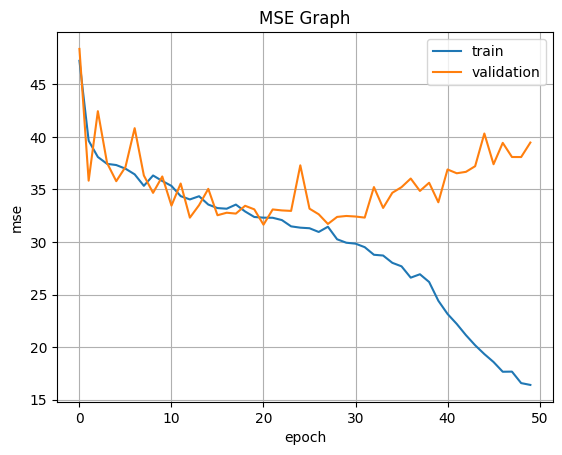

In [274]:
plt.plot(historyResNet.history['mse'])
plt.plot(historyResNet.history['val_mse'])
plt.title('MSE Graph')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.grid()
plt.show()

### 모델 위치 정상 예측 확인

In [275]:
# train 데이터셋 첫번째 이미지의 최대하락 위치 예측
modelResNet.predict((np.array(result['image']['train'][0]).astype(np.float32) / 255.0).reshape((1, 32, 32, 3)))

1/1 [==============================] - 1s 816ms/step


array([[ 7.7937164, 19.44315  ]], dtype=float32)

### 모델 예측에 대한 테스트 데이터셋 오차 확인

In [276]:
xSum = 0
ySum = 0
for idx,res in enumerate(zip(modelResNet.predict(np.array(waterAITrainDatasetResNet[2]).astype(np.float32) / 255.0), waterAITrainDatasetResNet[3])):
    xSum += abs(res[0][0] - res[1][0])
    ySum += abs(res[0][1] - res[1][1])

print('x평균오차: {}, y평균오차: {}'.format(xSum/idx, ySum/idx))

91/91 [==============================] - 1s 13ms/step
x평균오차: 4.077929386903973, y평균오차: 5.915710518957425


### 랜덤 지정에 대한 테스트 데이터셋 오차 확인

In [277]:
randList = []
for xy in zip(random.choices(range(0,17), k=len(waterAITrainDatasetResNet[3])), random.choices(range(0,30), k=len(waterAITrainDatasetResNet[3]))):
    randList.append(xy)

xSum = 0
ySum = 0
for idx,res in enumerate(zip(randList, waterAITrainDatasetResNet[3])):
    xSum += abs(res[0][0] - res[1][0])
    ySum += abs(res[0][1] - res[1][1])

print('x평균오차: {}, y평균오차: {}'.format(xSum/idx, ySum/idx))

x평균오차: 5.53469812630118, y평균오차: 8.962526023594727


------------------
------------------

### CNN인식 모델에서 예측위치의 confidence 하락률 검증 (테스트 데이터셋 대상)

In [278]:
modelName='CNN'
averageDown = 0

for data in zip(modelResNet.predict(np.array(waterAITrainDatasetCNN[2]).astype(np.float32) / 255.0), waterAITrainDatasetCNN[5]):
    
    noWatermarkImageConfidenceArray = result[modelName]['test'][data[1]][0]
    # 이미지AI 모델의 원본이미지에 대한 confidence
    imageAILabelNoWatermarkImageConfidence = noWatermarkImageConfidenceArray[noWatermarkImageConfidenceArray.argmax()]
    
    # 만약 이미지 크기를 벗어낫 위치를 예측한다면 pass
    if (int(data[0][0]) * 30) + int(data[0][1]) + 1 >= 511:
        print('!!!!!over pass')
        continue
    
    # 워터마크 위치AI가 예측한 위치의 이미지AI(CNN)의 인식률 확인
    watermarkPositionAIModelConfidence = result[modelName]['test'][
        data[1]                             # 이미지 번호
    ][
        (int(data[0][0]) * 30) +            # x축 위치
        int(data[0][1]) +                   # y축 위치
        + 1                                 # 가장 앞에 원본 이미지가 있으므로 +1
    ][
        noWatermarkImageConfidenceArray.argmax()    # 이미지 AI 가 예측한 라벨
    ]
    
    #print('{} -> {}'.format(imageAILabelNoWatermarkImageConfidence, watermarkPositionAIModelConfidence))
    averageDown += (imageAILabelNoWatermarkImageConfidence - watermarkPositionAIModelConfidence) / imageAILabelNoWatermarkImageConfidence * 100

print('평균 하락율(%): ', averageDown / idx)

91/91 [==============================] - 1s 13ms/step
평균 하락율(%):  11.248812086776141


------------------------
------------------------

### VGG19인식 모델에서 예측위치의 confidence 하락률 검증 (테스트 데이터셋 대상)

In [279]:
modelName='VGG19'
averageDown = 0

for data in zip(modelResNet.predict(np.array(waterAITrainDatasetVGG19[2])).astype(np.float32) / 255.0, waterAITrainDatasetVGG19[5]):
    
    noWatermarkImageConfidenceArray = result[modelName]['test'][data[1]][0]
    # 이미지AI 모델의 원본이미지에 대한 confidence
    imageAILabelNoWatermarkImageConfidence = noWatermarkImageConfidenceArray[noWatermarkImageConfidenceArray.argmax()]
    
    # 만약 이미지 크기를 벗어낫 위치를 예측한다면 pass
    if (int(data[0][0]) * 30) + int(data[0][1]) + 1 >= 511:
        print('!!!!!over pass')
        continue
    
    # 워터마크 위치AI가 예측한 위치의 이미지AI(VGG19)의 인식률 확인
    watermarkPositionAIModelConfidence = result[modelName]['test'][
        data[1]                             # 이미지 번호
    ][
        (int(data[0][0]) * 30) +            # x축 위치
        int(data[0][1]) +                   # y축 위치
        + 1                                 # 가장 앞에 원본 이미지가 있으므로 +1
    ][
        noWatermarkImageConfidenceArray.argmax()    # 이미지 AI 가 예측한 라벨
    ]
    
    #print('{} -> {}'.format(imageAILabelNoWatermarkImageConfidence, watermarkPositionAIModelConfidence))
    averageDown += (imageAILabelNoWatermarkImageConfidence - watermarkPositionAIModelConfidence) / imageAILabelNoWatermarkImageConfidence * 100

print('평균 하락율(%): ', averageDown / idx)

86/86 [==============================] - 2s 13ms/step
평균 하락율(%):  3.3052449895819582


------------------------
------------------------

### ResNet인식 모델에서 예측위치의 confidence 하락률 검증 (테스트 데이터셋 대상)

In [280]:
modelName='ResNet'
averageDown = 0

for data in zip(modelResNet.predict(np.array(waterAITrainDatasetResNet[2])).astype(np.float32) / 255.0, waterAITrainDatasetResNet[5]):
    
    noWatermarkImageConfidenceArray = result[modelName]['test'][data[1]][0]
    # 이미지AI 모델의 원본이미지에 대한 confidence
    imageAILabelNoWatermarkImageConfidence = noWatermarkImageConfidenceArray[noWatermarkImageConfidenceArray.argmax()]
    
    # 만약 이미지 크기를 벗어낫 위치를 예측한다면 pass
    if (int(data[0][0]) * 30) + int(data[0][1]) + 1 >= 511:
        print('!!!!!over pass')
        continue
    
    # 워터마크 위치AI가 예측한 위치의 이미지AI(ResNet)의 인식률 확인
    watermarkPositionAIModelConfidence = result[modelName]['test'][
        data[1]                             # 이미지 번호
    ][
        (int(data[0][0]) * 30) +            # x축 위치
        int(data[0][1]) +                   # y축 위치
        + 1                                 # 가장 앞에 원본 이미지가 있으므로 +1
    ][
        noWatermarkImageConfidenceArray.argmax()    # 이미지 AI 가 예측한 라벨
    ]
    
    #print('{} -> {}'.format(imageAILabelNoWatermarkImageConfidence, watermarkPositionAIModelConfidence))
    averageDown += (imageAILabelNoWatermarkImageConfidence - watermarkPositionAIModelConfidence) / imageAILabelNoWatermarkImageConfidence * 100

print('평균 하락율(%): ', averageDown / idx)

91/91 [==============================] - 1s 13ms/step
평균 하락율(%):  4.8508072995831055


-------------------
-------------------

### Base 모델: 랜덤

### 랜덤위치의 confidence 하락률 검증 (테스트 데이터셋 대상)

In [354]:
for modelName in ['CNN', 'VGG19', 'ResNet']:
    if modelName == 'CNN':
        testSetLength = len(waterAITrainDatasetCNN[5])
        testSet = waterAITrainDatasetCNN[5]
    elif modelName == 'VGG19':
        testSetLength = len(waterAITrainDatasetVGG19[5])
        testSet = waterAITrainDatasetVGG19[5]
    elif modelName == 'ResNet':
        testSetLength = len(waterAITrainDatasetResNet[5])
        testSet = waterAITrainDatasetResNet[5]


    randList = []
    for xy in zip(random.choices(range(0,17), k=testSetLength), random.choices(range(0,30), k=testSetLength)):
        randList.append(xy)

    averageDown = 0

    for data in zip(randList, testSet):

        noWatermarkImageConfidenceArray = result[modelName]['test'][data[1]][0]
        # 이미지AI 모델의 원본이미지에 대한 confidence
        imageAILabelNoWatermarkImageConfidence = noWatermarkImageConfidenceArray[noWatermarkImageConfidenceArray.argmax()]

        # 만약 이미지 크기를 벗어낫 위치를 예측한다면 pass
        if (int(data[0][0]) * 30) + int(data[0][1]) + 1 >= 511:
            print('!!!!!over pass')
            continue

        # 워터마크 위치AI가 예측한 위치의 이미지AI(CNN)의 인식률 확인
        watermarkPositionAIModelConfidence = result[modelName]['test'][
            data[1]                             # 이미지 번호
        ][
            (int(data[0][0]) * 30) +            # x축 위치
            int(data[0][1]) +                   # y축 위치
            + 1                                 # 가장 앞에 원본 이미지가 있으므로 +1
        ][
            noWatermarkImageConfidenceArray.argmax()    # 이미지 AI 가 예측한 라벨
        ]

        #print('{} -> {}'.format(imageAILabelNoWatermarkImageConfidence, watermarkPositionAIModelConfidence))
        averageDown += (imageAILabelNoWatermarkImageConfidence - watermarkPositionAIModelConfidence) / imageAILabelNoWatermarkImageConfidence * 100

    print(modelName, '평균 하락율(%): ', averageDown / idx)

CNN 평균 하락율(%):  6.8836510793777315
VGG19 평균 하락율(%):  9.710607363498738
ResNet 평균 하락율(%):  8.00009255523678


### Base 모델: 정중앙 워터마크

In [367]:
for modelName in ['CNN', 'VGG19', 'ResNet']:
    if modelName == 'CNN':
        testSetLength = len(waterAITrainDatasetCNN[5])
        testSet = waterAITrainDatasetCNN[5]
    elif modelName == 'VGG19':
        testSetLength = len(waterAITrainDatasetVGG19[5])
        testSet = waterAITrainDatasetVGG19[5]
    elif modelName == 'ResNet':
        testSetLength = len(waterAITrainDatasetResNet[5])
        testSet = waterAITrainDatasetResNet[5]


    randList = []
    for xy in zip(random.choices(range(7,8), k=testSetLength), random.choices(range(14,15), k=testSetLength)):
        randList.append(xy)

    averageDown = 0

    for data in zip(randList, testSet):

        noWatermarkImageConfidenceArray = result[modelName]['test'][data[1]][0]
        # 이미지AI 모델의 원본이미지에 대한 confidence
        imageAILabelNoWatermarkImageConfidence = noWatermarkImageConfidenceArray[noWatermarkImageConfidenceArray.argmax()]

        # 만약 이미지 크기를 벗어낫 위치를 예측한다면 pass
        if (int(data[0][0]) * 30) + int(data[0][1]) + 1 >= 511:
            print('!!!!!over pass')
            continue

        # 워터마크 위치AI가 예측한 위치의 이미지AI(CNN)의 인식률 확인
        watermarkPositionAIModelConfidence = result[modelName]['test'][
            data[1]                             # 이미지 번호
        ][
            (int(data[0][0]) * 30) +            # x축 위치
            int(data[0][1]) +                   # y축 위치
            + 1                                 # 가장 앞에 원본 이미지가 있으므로 +1
        ][
            noWatermarkImageConfidenceArray.argmax()    # 이미지 AI 가 예측한 라벨
        ]

        #print('{} -> {}'.format(imageAILabelNoWatermarkImageConfidence, watermarkPositionAIModelConfidence))
        averageDown += (imageAILabelNoWatermarkImageConfidence - watermarkPositionAIModelConfidence) / imageAILabelNoWatermarkImageConfidence * 100

    print(modelName, '평균 하락율(%): ', averageDown / idx)

CNN 평균 하락율(%):  12.069337045310563
VGG19 평균 하락율(%):  15.189473601571951
ResNet 평균 하락율(%):  10.9575536171899


-----------------------
-----------------------

### 예측 위치 분포 확인

In [387]:
modelCNNPredict = modelCNN.predict(np.array(waterAITrainDatasetCNN[2]).astype(np.float32) / 255.0)
modelVGG19Predict = modelVGG19.predict(np.array(waterAITrainDatasetVGG19[2]).astype(np.float32) / 255.0)
modelResNetPredict = modelResNet.predict(np.array(waterAITrainDatasetResNet[2]).astype(np.float32) / 255.0)

91/91 [==============================] - 1s 13ms/step


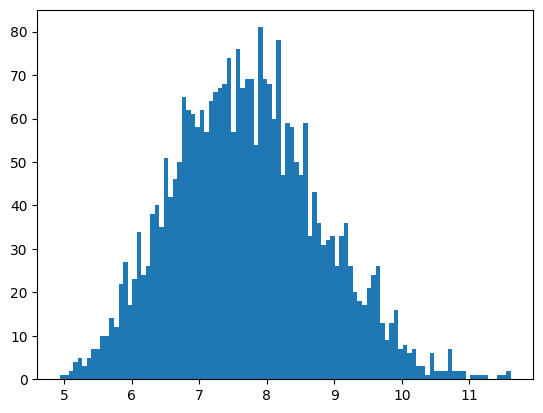

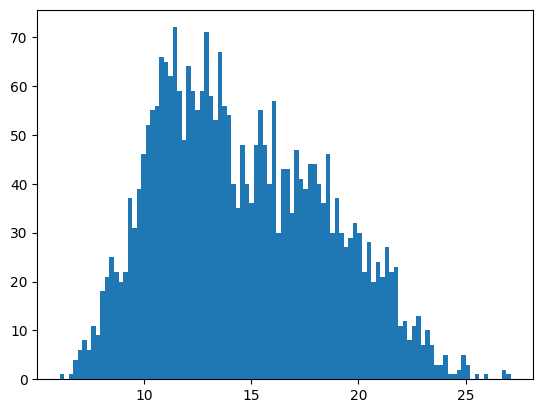

In [391]:
plt.hist([pos[0] for pos in modelCNNPredict], bins=100)
plt.show()
plt.hist([pos[1] for pos in modelCNNPredict], bins=100)
plt.show()

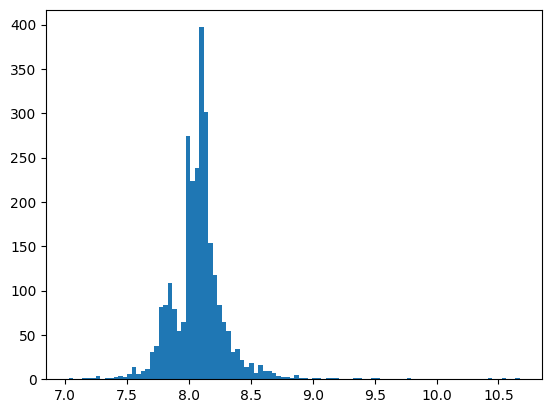

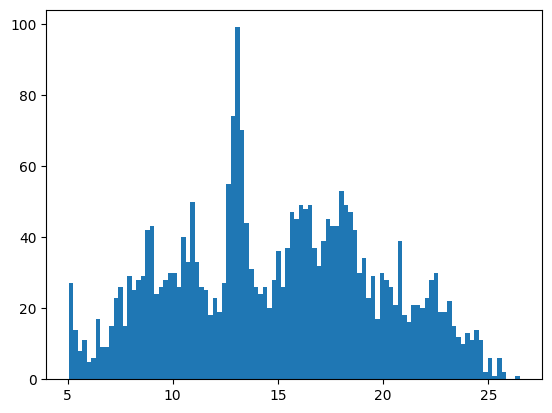

In [392]:
plt.hist([pos[0] for pos in modelVGG19Predict], bins=100)
plt.show()
plt.hist([pos[1] for pos in modelVGG19Predict], bins=100)
plt.show()

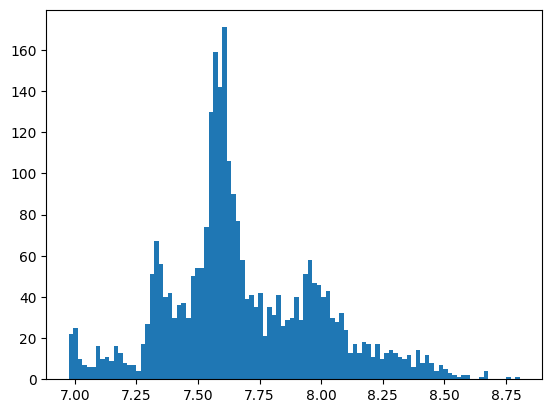

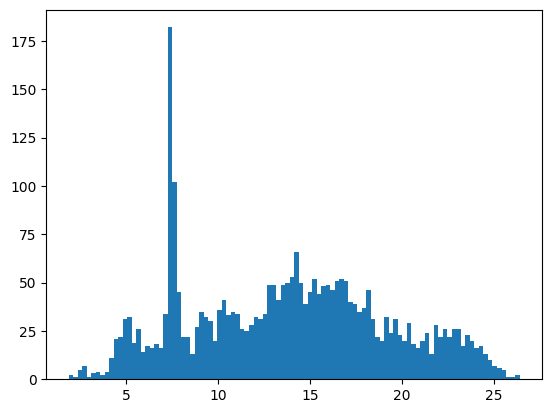

In [393]:
plt.hist([pos[0] for pos in modelResNetPredict], bins=100)
plt.show()
plt.hist([pos[1] for pos in modelResNetPredict], bins=100)
plt.show()